# Import libraries and setup

In [1]:
# Import libraries we may need
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import scanpy.external as sce
import wget
import yaml
import wget
import astir
import dill
#import umap
#import fa2
#reducer = umap.UMAP()
import squidpy as sq
import anndata as ad
from scipy.sparse import block_diag
from mofapy2.run.entry_point import entry_point

#My module for importing IMC data into AnnData format
import mikeimc as mimc

/Users/joaoluizsfilho/opt/anaconda3/envs/Squidpy/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/joaoluizsfilho/opt/anaconda3/envs/Squidpy/lib/python3.9/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/Users/joaoluizsfilho/opt/anaconda3/envs/Squidpy/lib/python3.

In [2]:
# Set up output figure settings
plt.rcParams['figure.figsize']=(64,64) #rescale figures, increase sizehere

# Set up scanpy settings
sc.settings.verbosity = 3
sc.set_figure_params(dpi=100, dpi_save=300) #Increase DPI for better resolution figures
#sc.logging.print_versions()

In [ ]:
#load the session
dill.load_session('DC_notebook_iteration3_SQUIDPY.db')

In [ ]:
#save the session
dill.dump_session('DC_notebook_iteration3_SQUIDPY.db')

In [3]:
#this object does not contain RBCs and non-covid ROIs
adata_subset4 = ad.read('./Analysis/9_SpOOx/adata_subset4.h5ad')

# Squidpy - neighbourhood analysis

In [ ]:
#The .copy() makes a completely seperate copy for neigh analysis
adata_subset4 = adata_subset3.copy()

In [ ]:
adata_subset4 = ad.read('adata_subset4.h5ad')

In [4]:
adata_subset4

AnnData object with n_obs × n_vars = 77314 × 38
    obs: 'Master_Index', 'ROI', 'Case', 'Type', 'X_loc', 'Y_loc', 'HEClass', 'cell_type', 'hierarchy', 'pheno_cluster', 'pheno_cluster_edited'
    uns: 'cell_type_nhood_enrichment', 'dendrogram_cell_type', 'dendrogram_pheno_cluster', 'dendrogram_pheno_cluster_edited', 'neighbors', 'pheno_cluster_edited_colors', 'pheno_cluster_nhood_enrichment', 'spatial_neighbors', 'tsne', 'umap'
    obsm: 'X_tsne', 'X_umap', 'spatial'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [ ]:
adata_subset4.obs['pheno_cluster']

In [ ]:
col_df = pd.read_csv('mikeimc_approach/colours/pheno_colours.csv')
colour_palette = col_df.set_index('pheno_cluster').to_dict()
colour_palette['colour']

In [ ]:
#create a copy of anndata and remove the RBC cluster
adata_subset5 = adata_subset4.copy()
adata_subset5 = adata_subset5[~adata_subset5.obs['pheno_cluster'].isin(['RBC']),:].copy()

In [ ]:
#save anndata objects
adata_subset4.write('adata_subset4')
adata_subset5.write('adata_subset5')

In [ ]:
adata_subset5 = ad.read('adata_subset5')

In [ ]:
#This code further filters the data by removing other groups
#The ~ sign indicates to the code to not include what is in the selection
#remove the ~ sign to include what is in the selection
adata_non_covid = adata_subset5[~adata_subset5.obs['Type'].isin(['Early death', 'Late death']),:].copy()
adata_non_covid = adata_non_covid[~adata_non_covid.obs['pheno_cluster'].isin(['Virus-infected Epithelial cell']),:].copy()

In [ ]:
#keep all covid cases
adata_covid = adata_subset5[~adata_subset5.obs['Type'].isin(['Non_COVID']),:].copy()

In [ ]:
#This code further filters the data by removing other groups
adata_early_death = adata_subset4[~adata_subset4.obs['Type'].isin(['Non_COVID', 'Late death']),:].copy()

In [ ]:
#This code further filters the data by removing other groups
adata_late_death = adata_subset4[~adata_subset4.obs['Type'].isin(['Non_COVID', 'Early death']),:].copy()

In [ ]:
adata_late_death

In [ ]:
adata_early_death

In [ ]:
#save anndata objects
adata_early_death.write('adata_ED.h5ad')
adata_late_death.write('adata_LD.h5ad')

In [ ]:
adata_early_death = ad.read('./Analysis/6_imcrtools/adata_ED.h5ad')
adata_late_death = ad.read('./Analysis/6_imcrtools/adata_LD.h5ad')

In [ ]:
adata_early_death.write_csvs(dirname='./adata_ED', skip_data=False)
adata_late_death.write_csvs(dirname='./adata_LD', skip_data=False)

# Subset anndata to run Squidpy analysis in batch

In [ ]:
adata_non_covid.obs["ROI"]

In [ ]:
adata_non_covid1 = adata_non_covid[adata_non_covid.obs['ROI'].isin(['N18_ROI1'])].copy()
adata_non_covid2 = adata_non_covid[adata_non_covid.obs['ROI'].isin(['N18_ROI2'])].copy()
adata_non_covid3 = adata_non_covid[adata_non_covid.obs['ROI'].isin(['N18_ROI3'])].copy()
adata_non_covid4 = adata_non_covid[adata_non_covid.obs['ROI'].isin(['N18_ROI4'])].copy()

In [ ]:
adata_list = adata_non_covid1, adata_non_covid2, adata_non_covid3, adata_non_covid4

for a in adata_list:
    sq.gr.spatial_neighbors(a, coord_type = 'generic', n_neighs=4)

In [ ]:
adata_non_covid_merge = ad.concat(adata_list, uns_merge='same')

In [ ]:
adata_non_covid_merge.obsp['spatial_connectivities'] = block_diag([a.obsp['spatial_connectivities'] for a in adata_list]).tocsr()
adata_non_covid_merge.obsp['spatial_distances'] = block_diag([a.obsp['spatial_distances'] for a in adata_list]).tocsr()

In [ ]:
#Change type to categorical
adata_non_covid_merge.obs['pheno_cluster']=adata_non_covid_merge.obs['pheno_cluster'].astype('category')

In [ ]:
adata_covid.obs["ROI"]

In [ ]:
adata_covid1 = adata_covid[adata_covid.obs['ROI'].isin(['C07_ROI1'])].copy()
adata_covid2 = adata_covid[adata_covid.obs['ROI'].isin(['C07_ROI2'])].copy()
adata_covid3 = adata_covid[adata_covid.obs['ROI'].isin(['C07_ROI3'])].copy()
adata_covid4 = adata_covid[adata_covid.obs['ROI'].isin(['C07_ROI4'])].copy()
adata_covid5 = adata_covid[adata_covid.obs['ROI'].isin(['C16_ROI1'])].copy()
adata_covid6 = adata_covid[adata_covid.obs['ROI'].isin(['C16_ROI2'])].copy()
adata_covid7 = adata_covid[adata_covid.obs['ROI'].isin(['C16_ROI3'])].copy()
adata_covid8 = adata_covid[adata_covid.obs['ROI'].isin(['C16_ROI4'])].copy()
adata_covid9 = adata_covid[adata_covid.obs['ROI'].isin(['C12_ROI1'])].copy()
adata_covid10 = adata_covid[adata_covid.obs['ROI'].isin(['C12_ROI2'])].copy()
adata_covid11 = adata_covid[adata_covid.obs['ROI'].isin(['C12_ROI3'])].copy()
adata_covid12 = adata_covid[adata_covid.obs['ROI'].isin(['C12_ROI4'])].copy()
adata_covid13 = adata_covid[adata_covid.obs['ROI'].isin(['C13_ROI1'])].copy()
adata_covid14 = adata_covid[adata_covid.obs['ROI'].isin(['C13_ROI2'])].copy()
adata_covid15 = adata_covid[adata_covid.obs['ROI'].isin(['C13_ROI3'])].copy()
adata_covid16 = adata_covid[adata_covid.obs['ROI'].isin(['C13_ROI4'])].copy()
adata_covid17 = adata_covid[adata_covid.obs['ROI'].isin(['C21_ROI1'])].copy()
adata_covid18 = adata_covid[adata_covid.obs['ROI'].isin(['C21_ROI2'])].copy()
adata_covid19 = adata_covid[adata_covid.obs['ROI'].isin(['C21_ROI4'])].copy()
adata_covid20 = adata_covid[adata_covid.obs['ROI'].isin(['C22_ROI1'])].copy()
adata_covid21 = adata_covid[adata_covid.obs['ROI'].isin(['C22_ROI2'])].copy()
adata_covid22 = adata_covid[adata_covid.obs['ROI'].isin(['C22_ROI3'])].copy()
adata_covid23 = adata_covid[adata_covid.obs['ROI'].isin(['C22_ROI4'])].copy()
adata_covid24 = adata_covid[adata_covid.obs['ROI'].isin(['C27_ROI1'])].copy()
adata_covid25 = adata_covid[adata_covid.obs['ROI'].isin(['C27_ROI2'])].copy()
adata_covid26 = adata_covid[adata_covid.obs['ROI'].isin(['C27_ROI3'])].copy()
adata_covid27 = adata_covid[adata_covid.obs['ROI'].isin(['C27_ROI4'])].copy()
adata_covid28 = adata_covid[adata_covid.obs['ROI'].isin(['C29_ROI2'])].copy()
adata_covid29 = adata_covid[adata_covid.obs['ROI'].isin(['C29_ROI3'])].copy()
adata_covid30 = adata_covid[adata_covid.obs['ROI'].isin(['C29_ROI4'])].copy()

In [ ]:
#save adata for specific ROIs to play in the ATHENA package
#adata_covid13.write('adata_C13_ROI1')
#adata_covid14.write('adata_C13_ROI2')
#adata_covid15.write('adata_C13_ROI3')
#adata_covid16.write('adata_C13_ROI4')

adata_covid1.write('adata_C07_ROI1')
adata_covid2.write('adata_C07_ROI2')
adata_covid3.write('adata_C07_ROI3')
adata_covid4.write('adata_C07_ROI4')
adata_covid5.write('adata_C16_ROI1')
adata_covid6.write('adata_C16_ROI2')
adata_covid7.write('adata_C16_ROI3')
adata_covid8.write('adata_C16_ROI4')
adata_covid9.write('adata_C12_ROI1')
adata_covid10.write('adata_C12_ROI2')
adata_covid11.write('adata_C12_ROI3')
adata_covid12.write('adata_C12_ROI4')
adata_covid17.write('adata_C21_ROI1')
adata_covid18.write('adata_C21_ROI2')
adata_covid19.write('adata_C21_ROI4')
adata_covid20.write('adata_C22_ROI1')
adata_covid21.write('adata_C22_ROI2')
adata_covid22.write('adata_C22_ROI3')
adata_covid23.write('adata_C22_ROI4')
adata_covid24.write('adata_C27_ROI1')
adata_covid25.write('adata_C27_ROI2')
adata_covid26.write('adata_C27_ROI3')
adata_covid27.write('adata_C27_ROI4')
adata_covid28.write('adata_C29_ROI2')
adata_covid29.write('adata_C29_ROI3')
adata_covid30.write('adata_C29_ROI4')

In [ ]:
adata_list2 = adata_covid1, adata_covid2, adata_covid3, adata_covid4, adata_covid5, adata_covid6, adata_covid7, adata_covid8, adata_covid9, adata_covid10, adata_covid11, adata_covid12, adata_covid13, adata_covid14, adata_covid15, adata_covid16, adata_covid17, adata_covid18, adata_covid19, adata_covid20, adata_covid21, adata_covid22, adata_covid23, adata_covid24, adata_covid25, adata_covid26, adata_covid27, adata_covid28, adata_covid29, adata_covid30
for a in adata_list2:
    sq.gr.spatial_neighbors(a, coord_type = 'generic', n_neighs=4)

In [ ]:
adata_covid_merge = ad.concat(adata_list2, uns_merge='same')

In [ ]:
adata_covid_merge.obsp['spatial_connectivities'] = block_diag([a.obsp['spatial_connectivities'] for a in adata_list2]).tocsr()
adata_covid_merge.obsp['spatial_distances'] = block_diag([a.obsp['spatial_distances'] for a in adata_list2]).tocsr()

In [ ]:
#Change type to categorical
adata_covid_merge.obs['pheno_cluster']=adata_covid_merge.obs['pheno_cluster'].astype('category')

In [ ]:
adata_late_death1 = adata_late_death[adata_late_death.obs['ROI'].isin(['C07_ROI1'])].copy()
adata_late_death2 = adata_late_death[adata_late_death.obs['ROI'].isin(['C07_ROI2'])].copy()
adata_late_death3 = adata_late_death[adata_late_death.obs['ROI'].isin(['C07_ROI3'])].copy()
adata_late_death4 = adata_late_death[adata_late_death.obs['ROI'].isin(['C07_ROI4'])].copy()
adata_late_death5 = adata_late_death[adata_late_death.obs['ROI'].isin(['C16_ROI1'])].copy()
adata_late_death6 = adata_late_death[adata_late_death.obs['ROI'].isin(['C16_ROI2'])].copy()
adata_late_death7 = adata_late_death[adata_late_death.obs['ROI'].isin(['C16_ROI3'])].copy()
adata_late_death8 = adata_late_death[adata_late_death.obs['ROI'].isin(['C16_ROI4'])].copy()

In [ ]:
adata_list3 = adata_late_death1, adata_late_death2, adata_late_death3, adata_late_death4, adata_late_death5, adata_late_death6, adata_late_death7, adata_late_death8
for a in adata_list3:
    sq.gr.spatial_neighbors(a, coord_type = 'generic', n_neighs=4)
    sq.gr.nhood_enrichment(a, cluster_key="pheno_cluster", seed=1234, copy=False)

In [ ]:
adata_late_death_merge = ad.concat(adata_list3, uns_merge='same')

In [ ]:
adata_late_death_merge.obsp['spatial_connectivities'] = block_diag([a.obsp['spatial_connectivities'] for a in adata_list3]).tocsr()
adata_late_death_merge.obsp['spatial_distances'] = block_diag([a.obsp['spatial_distances'] for a in adata_list3]).tocsr()

In [ ]:
#Change type to categorical
adata_late_death_merge.obs['pheno_cluster'] = adata_late_death_merge.obs['pheno_cluster'].astype('category')

In [ ]:
#Re-annotation of the clusters in a dictionary file

covid_dict = pd.read_csv('mikeimc_approach/Dictionaries/covid_pheno_cluster_edited_dict.csv')
ep = covid_dict.set_index('pheno_cluster').to_dict()

adata_late_death_merge.obs['pheno_cluster_edited']=adata_late_death_merge.obs['pheno_cluster'].map(ep['Cell_Class'])

adata_late_death_merge.obs['pheno_cluster_edited']=adata_late_death_merge.obs['pheno_cluster_edited'].astype('category')

In [ ]:
adata_early_death1 = adata_early_death[adata_early_death.obs['ROI'].isin(['C12_ROI1'])].copy()
adata_early_death2 = adata_early_death[adata_early_death.obs['ROI'].isin(['C12_ROI2'])].copy()
adata_early_death3 = adata_early_death[adata_early_death.obs['ROI'].isin(['C12_ROI3'])].copy()
adata_early_death4 = adata_early_death[adata_early_death.obs['ROI'].isin(['C12_ROI4'])].copy()
adata_early_death5 = adata_early_death[adata_early_death.obs['ROI'].isin(['C13_ROI1'])].copy()
adata_early_death6 = adata_early_death[adata_early_death.obs['ROI'].isin(['C13_ROI2'])].copy()
adata_early_death7 = adata_early_death[adata_early_death.obs['ROI'].isin(['C13_ROI3'])].copy()
adata_early_death8 = adata_early_death[adata_early_death.obs['ROI'].isin(['C13_ROI4'])].copy()
adata_early_death9 = adata_early_death[adata_early_death.obs['ROI'].isin(['C21_ROI1'])].copy()
adata_early_death10 = adata_early_death[adata_early_death.obs['ROI'].isin(['C21_ROI2'])].copy()
adata_early_death11 = adata_early_death[adata_early_death.obs['ROI'].isin(['C21_ROI4'])].copy()
adata_early_death12 = adata_early_death[adata_early_death.obs['ROI'].isin(['C22_ROI1'])].copy()
adata_early_death13 = adata_early_death[adata_early_death.obs['ROI'].isin(['C22_ROI2'])].copy()
adata_early_death14 = adata_early_death[adata_early_death.obs['ROI'].isin(['C22_ROI3'])].copy()
adata_early_death15 = adata_early_death[adata_early_death.obs['ROI'].isin(['C22_ROI4'])].copy()
adata_early_death16 = adata_early_death[adata_early_death.obs['ROI'].isin(['C27_ROI1'])].copy()
adata_early_death17 = adata_early_death[adata_early_death.obs['ROI'].isin(['C27_ROI2'])].copy()
adata_early_death18 = adata_early_death[adata_early_death.obs['ROI'].isin(['C27_ROI3'])].copy()
adata_early_death19 = adata_early_death[adata_early_death.obs['ROI'].isin(['C27_ROI4'])].copy()
adata_early_death20 = adata_early_death[adata_early_death.obs['ROI'].isin(['C29_ROI2'])].copy()
adata_early_death21 = adata_early_death[adata_early_death.obs['ROI'].isin(['C29_ROI3'])].copy()
adata_early_death22 = adata_early_death[adata_early_death.obs['ROI'].isin(['C29_ROI4'])].copy()

In [ ]:
adata_list4 = adata_early_death1, adata_early_death2, adata_early_death3, adata_early_death4, adata_early_death5, adata_early_death6, adata_early_death7, adata_early_death8, adata_early_death9, adata_early_death10, adata_early_death11, adata_early_death12, adata_early_death14, adata_early_death15, adata_early_death16, adata_early_death17, adata_early_death18, adata_early_death19, adata_early_death20, adata_early_death21, adata_early_death22
for a in adata_list4:
    sq.gr.spatial_neighbors(a, coord_type = 'generic', n_neighs=4)

In [ ]:
adata_early_death_merge = ad.concat(adata_list4, uns_merge='same')

In [ ]:
adata_early_death_merge.obsp['spatial_connectivities'] = block_diag([a.obsp['spatial_connectivities'] for a in adata_list4]).tocsr()
adata_early_death_merge.obsp['spatial_distances'] = block_diag([a.obsp['spatial_distances'] for a in adata_list4]).tocsr()

In [ ]:
#Change type to categorical
adata_early_death_merge.obs['pheno_cluster'] = adata_early_death_merge.obs['pheno_cluster'].astype('category')

In [ ]:
#Re-annotation of the clusters in a dictionary file

covid_dict = pd.read_csv('mikeimc_approach/Dictionaries/covid_pheno_cluster_edited_dict.csv')
ep = covid_dict.set_index('pheno_cluster').to_dict()

adata_early_death_merge.obs['pheno_cluster_edited']=adata_early_death_merge.obs['pheno_cluster'].map(ep['Cell_Class'])

adata_early_death_merge.obs['pheno_cluster_edited']=adata_early_death_merge.obs['pheno_cluster_edited'].astype('category')

In [ ]:
col_df = pd.read_csv('mikeimc_approach/colours/pheno_colours.csv')
colour_palette = col_df.set_index('pheno_cluster').to_dict()
colour_palette['colour']

# Michael's solution to run Squidpy in batch

In [ ]:
import nhood_enrich as ne
import nhood_enrich_radius as nr
ne.nhood_enrichment_hyperion(adata_early_death,'pheno_cluster','ROI',average_over_rois=True)

#nr.nhood_enrichment_hyperion(adata_early_death,'pheno_cluster','ROI',average_over_rois=True)

In [ ]:
sq.pl.nhood_enrichment(adata_early_death, cluster_key="pheno_cluster", cmap='bwr', mode='zscore', vmin=-2, vmax=2, palette = colour_palette['colour'], save='NE_ED_zscore_pheno_cluster_average.pdf')
#method='ward', 

In [ ]:
#RUN NE per covid case instead of disease group to extract the z-scores for specific clusters interactions to be added in the integration analysis with IHC data
#prepare lists of adata objects per Case

adata_C07 = adata_covid[adata_covid.obs['ROI'].isin(['C07_ROI1', 'C07_ROI2', 'C07_ROI3', 'C07_ROI4'])].copy()
adata_C16 = adata_covid[adata_covid.obs['ROI'].isin(['C16_ROI1', 'C16_ROI2', 'C16_ROI3', 'C16_ROI4'])].copy()
adata_C12 = adata_covid[adata_covid.obs['ROI'].isin(['C12_ROI1', 'C12_ROI2', 'C12_ROI3', 'C12_ROI4'])].copy()
adata_C13 = adata_covid[adata_covid.obs['ROI'].isin(['C13_ROI1', 'C13_ROI2', 'C13_ROI3', 'C13_ROI4'])].copy()
adata_C21 = adata_covid[adata_covid.obs['ROI'].isin(['C21_ROI1', 'C21_ROI2', 'C21_ROI4'])].copy()
adata_C22 = adata_covid[adata_covid.obs['ROI'].isin(['C22_ROI1', 'C22_ROI2', 'C22_ROI3', 'C22_ROI4'])].copy()
adata_C27 = adata_covid[adata_covid.obs['ROI'].isin(['C27_ROI1', 'C27_ROI2', 'C27_ROI3', 'C27_ROI4'])].copy()
adata_C29 = adata_covid[adata_covid.obs['ROI'].isin(['C29_ROI2', 'C29_ROI3', 'C29_ROI4'])].copy()

In [ ]:
import nhood_enrich as ne
ne.nhood_enrichment_hyperion(adata_covid17,'pheno_cluster','ROI',average_over_rois=True,run_initial=True)
ne.nhood_enrichment_hyperion(adata_covid18,'pheno_cluster','ROI',average_over_rois=True,run_initial=True)
ne.nhood_enrichment_hyperion(adata_covid19,'pheno_cluster','ROI',average_over_rois=True,run_initial=True)
ne.nhood_enrichment_hyperion(adata_covid20,'pheno_cluster','ROI',average_over_rois=True,run_initial=True)

In [ ]:
adata_covid30.uns['pheno_cluster_nhood_enrichment']

In [ ]:
sq.pl.nhood_enrichment(adata_covid20, cluster_key="pheno_cluster", cmap='bwr', vmin=-2, vmax=2, mode='zscore', palette = colour_palette['colour']) 

# # Spatial neighbors and neighborhood enrichment

In [ ]:
sq.gr.spatial_neighbors(adata_early_death, coord_type = 'generic', n_neighs=4)
#n_neighs=4, radius=2
#delaunay

In [ ]:
sq.gr.nhood_enrichment(adata_early_death, cluster_key="pheno_cluster", seed=1234, copy=False)

In [ ]:
adata_covid30.obs["ROI"]

In [ ]:
fields=['C29_ROI4']
for i in fields:
    sc.pl.spatial(adata_covid[adata_covid.obs["ROI"] == i], color ='pheno_cluster', neighbors_key="spatial_neighbors", palette = colour_palette['colour'], spot_size=20, edges=True, edges_width=2, edges_color='black', img_key=None, title=i, add_outline=True,return_fig=True) 

In [ ]:
sq.pl.nhood_enrichment(adata_covid26, cluster_key="pheno_cluster", cmap='bwr', mode='zscore', palette = colour_palette['colour']) 

#save='NE_COVID_zscore_pheno_cluster_ward.png')
#method = 'ward',

In [ ]:
sq.pl.nhood_enrichment(adata_covid2, cluster_key="pheno_cluster", vmax=100, cmap='bwr', palette = colour_palette['colour'], mode='count') 
                       #save='NE_LD_count_pheno_cluster.png')

In [ ]:
adata_early_death

In [ ]:
#Early death: use cases where there is no tissue image, compute a spatial graph based on a fixed neighbor radius that is informative given your experimental settings.
#method: using outputs from Michael's function
fields=['C12_ROI1','C12_ROI2','C12_ROI3','C12_ROI4','C13_ROI1','C13_ROI2','C13_ROI3','C13_ROI4',
       'C21_ROI1','C21_ROI2','C21_ROI4','C22_ROI1','C22_ROI2','C22_ROI3','C22_ROI4',
       'C27_ROI1','C27_ROI2','C27_ROI3','C27_ROI4','C29_ROI2','C29_ROI3','C29_ROI4']
for i in fields:
    sc.pl.spatial(adata_early_death[adata_early_death.obs["ROI"] == i], color ='pheno_cluster', neighbors_key='spatial_neighbors', palette = colour_palette['colour'], spot_size=20, edges=True, edges_width=1, edges_color='black', img_key=None, title=i, add_outline=True,return_fig=True) 

In [ ]:
#Early death: use cases where there is no tissue image, compute a spatial graph based on a fixed neighbor radius that is informative given your experimental settings.
#method: using outputs from Michael's function and squidpy scatter function
fields=['C12_ROI1','C12_ROI2','C12_ROI3','C12_ROI4','C13_ROI1','C13_ROI2','C13_ROI3','C13_ROI4',
       'C21_ROI1','C21_ROI2','C21_ROI4','C22_ROI1','C22_ROI2','C22_ROI3','C22_ROI4',
       'C27_ROI1','C27_ROI2','C27_ROI3','C27_ROI4','C29_ROI2','C29_ROI3','C29_ROI4']
for i in fields:
    sq.pl.spatial_scatter(adata_early_death[adata_early_death.obs["ROI"] == i], shape=None, color ='pheno_cluster', palette=None, spatial_key='spatial', connectivity_key="spatial_connectivities", size=20, edges_width=1, edges_color='black', title=i) 

In [ ]:
#Early death: use cases where there is no tissue image, compute a spatial graph based on a fixed neighbor radius that is informative given your experimental settings.
#method: using outputs from Michael's function and selecting specific clusters of interactions
fields=['C12_ROI1','C12_ROI2','C12_ROI3','C12_ROI4','C13_ROI1','C13_ROI2','C13_ROI3','C13_ROI4',
       'C21_ROI1','C21_ROI2','C21_ROI4','C22_ROI1','C22_ROI2','C22_ROI3','C22_ROI4',
       'C27_ROI1','C27_ROI2','C27_ROI3','C27_ROI4','C29_ROI2','C29_ROI3','C29_ROI4']
for i in fields:
    sc.pl.spatial(adata_early_death[adata_early_death.obs["ROI"] == i], 
                  color ='pheno_cluster', 
                  palette = colour_palette['colour'], 
                  neighbors_key='spatial_neighbors', 
                  groups=["Interstitial Macrophage", "Virus-infected Epithelial cell"], 
                  spot_size=30, edges=False, edges_width=10, edges_color='black',  na_color='white',
                  img_key=None, title=i, add_outline=True,return_fig=True, save=str(i)+'.pdf') 

In [ ]:
#Late death: use cases where there is no tissue image, compute a spatial graph based on a fixed neighbor radius that is informative given your experimental settings.#
#method: using outputs from Michael's function
fields=['C07_ROI1','C07_ROI2','C07_ROI3','C07_ROI4',
       'C16_ROI1','C16_ROI2','C16_ROI3','C16_ROI4']
for i in fields:
    sc.pl.spatial(adata_late_death[adata_late_death.obs["ROI"] == i],
                  color ='pheno_cluster', 
                  palette = colour_palette['colour'], 
                  neighbors_key='spatial_neighbors', 
                  groups=["CD66bHigh Neutrophil", "Virus-infected Epithelial cell"], 
                  spot_size=30, edges=False, edges_width=10, edges_color='black',  na_color='white',
                  img_key=None, title=i, add_outline=True,return_fig=True, save=str(i)+'.pdf')

In [ ]:
#Early death: use cases where there is no tissue image, compute a spatial graph based on a fixed neighbor radius that is informative given your experimental settings.
#method: using outputs from 10X Visium function and selecting specific clusters of interactions
fields=['C12_ROI1','C12_ROI2','C12_ROI3','C12_ROI4','C13_ROI1','C13_ROI2','C13_ROI3','C13_ROI4',
       'C21_ROI1','C21_ROI2','C21_ROI4','C22_ROI1','C22_ROI3','C22_ROI4',
       'C27_ROI1','C27_ROI2','C27_ROI3','C27_ROI4','C29_ROI2','C29_ROI3','C29_ROI4']
for i in fields:
    sc.pl.spatial(adata_early_death_merge[adata_early_death_merge.obs["ROI"] == i], color ='pheno_cluster_edited', palette = colour_palette['colour2'], neighbors_key="spatial_neighbors", groups=["SARSCoV2+ Alveolar Macrophage", "Activated Endothelial cell"], spot_size=30, edges=True, edges_width=1, edges_color='black', na_color="white", na_in_legend=False, img_key=None, title=i, add_outline=True, outline_width=(0.3, 0.05), outline_color=('black', 'white'), return_fig=True) 

In [ ]:
#Late death: use cases where there is no tissue image, compute a spatial graph based on a fixed neighbor radius that is informative given your experimental settings.#
#method: using outputs from Michael's function
fields=['C07_ROI1','C07_ROI2','C07_ROI3','C07_ROI4',
       'C16_ROI1','C16_ROI2','C16_ROI3','C16_ROI4']
for i in fields:
    sc.pl.spatial(adata_late_death[adata_late_death.obs["ROI"] == i], neighbors_key="spatial_neighbors", palette = colour_palette['colour'], color="pheno_cluster", spot_size=30, edges=True, edges_width=1, edges_color='black', na_color="white", na_in_legend=False, img_key=None, title=i, add_outline=True, outline_width=(0.3, 0.05), outline_color=('black', 'white'), return_fig=True)    

In [ ]:
#Late death: use cases where there is no tissue image, compute a spatial graph based on a fixed neighbor radius that is informative given your experimental settings.
#method: using outputs from 10X Visium function
fields=['C07_ROI1','C07_ROI2','C07_ROI3','C07_ROI4',
       'C16_ROI1','C16_ROI2','C16_ROI3','C16_ROI4']
for i in fields:
    sc.pl.spatial(adata_late_death_merge[adata_late_death_merge.obs["ROI"] == i], neighbors_key="spatial_neighbors", color="pheno_cluster_edited", palette = colour_palette['colour2'], groups=["SARSCoV2+ Epithelial cell"], spot_size=30, edges=True, edges_width=1, edges_color='black', na_color="white", na_in_legend=False, img_key=None, title=i, add_outline=True, outline_width=(0.3, 0.05), outline_color=('black', 'white'), return_fig=True)
    

In [ ]:
#All COVID cases
#method: using outputs from Michael's function
fields=['C12_ROI1','C12_ROI2','C12_ROI3','C12_ROI4','C13_ROI1','C13_ROI2','C13_ROI3','C13_ROI4',
       'C21_ROI1','C21_ROI2','C21_ROI4','C22_ROI1','C22_ROI2','C22_ROI3','C22_ROI4',
       'C27_ROI1','C27_ROI2','C27_ROI3','C27_ROI4','C29_ROI2','C29_ROI3','C29_ROI4',
       'C07_ROI1','C07_ROI2','C07_ROI3','C07_ROI4',
       'C16_ROI1','C16_ROI2','C16_ROI3','C16_ROI4']
for i in fields:
    sc.pl.spatial(adata_covid[adata_covid.obs["ROI"] == i], color ='pheno_cluster', palette = colour_palette['colour'], neighbors_key="spatial_neighbors", spot_size=20, edges=True, edges_width=10, edges_color='black', img_key=None, title=i, add_outline=True,return_fig=True)
    
#groups=["Activated Endothelial cell", "Virus-infected Epithelial cell"],

In [ ]:
#All COVID cases
#method: using outputs from 10X Visium function
fields=['C12_ROI1','C12_ROI2','C12_ROI3','C12_ROI4','C13_ROI1','C13_ROI2','C13_ROI3','C13_ROI4',
       'C21_ROI1','C21_ROI2','C21_ROI4','C22_ROI1','C22_ROI2','C22_ROI3','C22_ROI4',
       'C27_ROI1','C27_ROI2','C27_ROI3','C27_ROI4','C29_ROI2','C29_ROI3','C29_ROI4',
       'C07_ROI1','C07_ROI2','C07_ROI3','C07_ROI4',
       'C16_ROI1','C16_ROI2','C16_ROI3','C16_ROI4']
for i in fields:
    sc.pl.spatial(adata_covid_merge[adata_covid_merge.obs["ROI"] == i], color ='pheno_cluster', palette = colour_palette['colour'], neighbors_key="spatial_neighbors", spot_size=30, edges=True, edges_width=1, edges_color='black', img_key=None, title=i, add_outline=True,return_fig=True)

#groups=["Virus-infected Alveolar Macrophage", "Interstitial Macrophage"],   


# Extract z-scores from Neighborhood Enrichment Analysis 

In [ ]:
adata_early_death_merge

In [ ]:
adata_early_death

In [ ]:
cat_name = 'pheno_cluster'
sig_leiden = pd.DataFrame(columns=adata_early_death_merge.var_names, index=adata_early_death_merge.obs[cat_name].cat.categories)

In [ ]:
sig_leiden = sig_leiden.transpose()
pheno_clusters = ['Cluster-' + str(x) for x in sig_leiden.columns.tolist()]

In [ ]:
pheno_clusters

In [ ]:
ser_counts = adata_early_death_merge.obs['pheno_cluster'].value_counts()
ser_counts.name = 'cell counts'
meta_leiden = pd.DataFrame(ser_counts)
#meta_leiden.index = pheno_clusters.columns.tolist()

In [ ]:
from scipy.cluster import hierarchy as sch
n_clusters = [4]
df_nhood_enr = pd.DataFrame(adata_early_death_merge.uns['pheno_cluster_nhood_enrichment']['zscore'], columns=pheno_clusters, index=pheno_clusters)
nhood_cluster_levels = ['Level-' + str(x) for x in n_clusters]
linkage = sch.linkage(df_nhood_enr, method='average')
mat_nhood_clusters = sch.cut_tree(linkage, n_clusters=n_clusters)
df_cluster = pd.DataFrame(mat_nhood_clusters, columns=nhood_cluster_levels,
                                index=meta_leiden.index.tolist())

In [ ]:
df_nhood_enr 

In [ ]:
inst_level = 'Level-' + str(n_clusters[0])
all_clusters = list(df_cluster[inst_level].unique())
# sc.set_figure_params(figsize=(10,10))
for inst_cluster in all_clusters:
  inst_clusters = df_cluster[df_cluster[inst_level] == inst_cluster].index.tolist()

In [ ]:
fields=['C12_ROI1','C12_ROI2','C12_ROI3','C12_ROI4','C13_ROI1','C13_ROI2','C13_ROI3','C13_ROI4',
       'C21_ROI1','C21_ROI2','C21_ROI4','C22_ROI1','C22_ROI2','C22_ROI3','C22_ROI4',
       'C27_ROI1','C27_ROI2','C27_ROI3','C27_ROI4','C29_ROI2','C29_ROI3','C29_ROI4']
for i in fields:
    sc.pl.spatial(adata_early_death[adata_early_death.obs["ROI"] == i], color ='pheno_cluster', palette=None, groups=inst_clusters,  neighbors_key="spatial_neighbors", spot_size=20, edges=True, edges_width=1, edges_color='black', na_color="white", na_in_legend=False, img_key=None, title=i, add_outline=True,return_fig=True) 

# Interaction Matrix

In [ ]:
#The function computes the number of shared edges in the neighbor graph between clusters.
sq.gr.interaction_matrix(adata_early_death_merge, cluster_key="pheno_cluster", normalized=False)

In [ ]:
sq.pl.interaction_matrix(adata_early_death_merge, cluster_key="pheno_cluster", vmax=2000, cmap='inferno', palette = colour_palette['colour'], save='ED_interaction_matrix_pheno_cluster.pdf' )


# Ripley’s statistics

In [ ]:
mode = "L"
sq.gr.ripley(adata_early_death_merge, cluster_key="pheno_cluster_edited", mode='L', max_dist=500, copy=False, seed=1234)

In [ ]:
sq.pl.ripley(adata_early_death_merge, cluster_key="pheno_cluster_edited", palette=colour_palette['colour2'], mode=mode, save='ED_ripley_pheno_cluster.pdf')


In [ ]:
#Plot spatial plots representing of the ripley's results

In [ ]:
#Early death: use cases where there is no tissue image, compute a spatial graph based on a fixed neighbor radius that is informative given your experimental settings.
#method: using outputs from Michael's function and selecting specific clusters of interactions
fields=['C12_ROI1','C12_ROI2','C12_ROI3','C12_ROI4','C13_ROI1','C13_ROI2','C13_ROI3','C13_ROI4',
       'C21_ROI1','C21_ROI2','C21_ROI4','C22_ROI1','C22_ROI2','C22_ROI3','C22_ROI4',
       'C27_ROI1','C27_ROI2','C27_ROI3','C27_ROI4','C29_ROI2','C29_ROI3','C29_ROI4']
for i in fields:
    sc.pl.spatial(adata_early_death[adata_early_death.obs["ROI"] == i], color ='pheno_cluster', palette = colour_palette['colour'], neighbors_key='spatial_neighbors', groups=["Virus-infected Alveolar Macrophage", "Interstitial Macrophage"], spot_size=20, edges=True, edges_width=10, edges_color='black', img_key=None, title=i, add_outline=True,return_fig=True) 

# Centrality Scores

In [ ]:
sq.gr.centrality_scores(
    adata_early_death_merge,
    cluster_key="pheno_cluster", copy=False
)

In [ ]:
sq.pl.centrality_scores(adata_early_death_merge, cluster_key="pheno_cluster", palette=colour_palette['colour'], figsize=(20, 10), s=500, save='ED_centrality_scores_pheno_cluster.png')


In [ ]:
#Save output panda data frame to csv file
df = sq.gr.centrality_scores(
    adata_late_death,
    cluster_key="pheno_cluster", copy=True
)

compression_opts = dict(method='zip',
                         archive_name='LD_centrality_scores_pheno_cluster.csv') 
df.to_csv('out.zip', index=True, compression=compression_opts)

In [ ]:
#All COVID cases
#method: using outputs from 10X Visium function
fields=['C12_ROI1','C12_ROI2','C12_ROI3','C12_ROI4','C13_ROI1','C13_ROI2','C13_ROI3','C13_ROI4',
       'C21_ROI1','C21_ROI2','C21_ROI4','C22_ROI1','C22_ROI2','C22_ROI3','C22_ROI4',
       'C27_ROI1','C27_ROI2','C27_ROI3','C27_ROI4','C29_ROI2','C29_ROI3','C29_ROI4',
       'C07_ROI1','C07_ROI2','C07_ROI3','C07_ROI4',
       'C16_ROI1','C16_ROI2','C16_ROI3','C16_ROI4']
for i in fields:
    sc.pl.spatial(adata_covid_merge[adata_covid_merge.obs["ROI"] == i], color ='pheno_cluster', palette = colour_palette['colour'], groups=["Activated Endothelial cell"], neighbors_key="spatial_neighbors", spot_size=30, edges=True, edges_width=1, edges_color='black', img_key=None, title=i, add_outline=True,return_fig=True)

In [ ]:
cluster_key = "pheno_cluster_edited"
sq.gr.centrality_scores(adata_early_death_merge, cluster_key, show_progress_bar=True)

In [ ]:
data = adata_early_death_merge.uns[f'{cluster_key}_centrality_scores'].reset_index()

fig, axs = plt.subplots(1, 3, figsize=(16, 6), dpi=300)
fig.tight_layout()
plt.subplots_adjust(wspace = 0.2)

for count, i in enumerate(['closeness_centrality','degree_centrality','average_clustering']):

    sb.barplot(data = data, 
               x = "index", 
               y = i, 
               ci=68,
               ax=axs[count],
               palette=colour_palette['colour2'],
              order=data.sort_values(i)['index']
              )
    
    #if i=='average_clustering':
        #axs[count].set(ylim=(0.48, 0.52))
    
    axs[count].set_title(i)
    axs[count].tick_params(axis='x', labelrotation = 90)
    axs[count].tick_params(axis='y', labelsize=18)
    plt.xticks(rotation=90)
    #axs[count].set_ylabel('Difference', fontsize=12)

fig.savefig('adata_ED_merge_network_centrality_scores.svg')

# Co-occurrence across spatial dimensions

In [ ]:
#Plot co-occurence score to visualize cluster co-occurrence in spatial dimensions using the original spatial coordinates. 
#We visualize the result for two conditional groups, here use the virus-infected cells.
sq.gr.co_occurrence(adata_early_death_merge, cluster_key='pheno_cluster_edited', spatial_key='spatial', copy=False)

In [ ]:
#from matplotlib.colors import ListedColormap

sq.pl.co_occurrence(
    adata_early_death_merge,
    cluster_key='pheno_cluster_edited',
    clusters=['CD66bHigh Neutrophil'],
    figsize=(20, 10), save='ED_ve_epithelial_cell_co_ocurrence.png'
)

In [ ]:
#All COVID cases
#method: using outputs from 10X Visium function
fields=['C12_ROI1','C12_ROI2','C12_ROI3','C12_ROI4','C13_ROI1','C13_ROI2','C13_ROI3','C13_ROI4',
       'C21_ROI1','C21_ROI2','C21_ROI4','C22_ROI1','C22_ROI2','C22_ROI3','C22_ROI4',
       'C27_ROI1','C27_ROI2','C27_ROI3','C27_ROI4','C29_ROI2','C29_ROI3','C29_ROI4',
       'C07_ROI1','C07_ROI2','C07_ROI3','C07_ROI4',
       'C16_ROI1','C16_ROI2','C16_ROI3','C16_ROI4']
for i in fields:
    sc.pl.spatial(adata_covid_merge[adata_covid_merge.obs["ROI"] == i], color ='pheno_cluster', palette = colour_palette['colour'], groups=["CD38+ CD4 T cell"], neighbors_key="spatial_neighbors", spot_size=30, edges=True, edges_width=1, edges_color='black', na_color="white", na_in_legend=False, img_key=None, title=i, add_outline=True, outline_width=(0.3, 0.05), outline_color=('black', 'white'), return_fig=True)    
    

# Spatially variable proteins with spatial autocorrelation statistics

In [ ]:
#two spatial autocorrelation statistics: Moran’s I and Geary’s C*. 
#They provide a score on the degree of spatial variability of gene expression. 
#The statistic as well as the p-value are computed for each gene, and FDR correction is performed. 
df = sq.gr.spatial_autocorr(adata_covid_merge, mode="moran")
adata_covid_merge.uns["moranI"].head(50)

In [ ]:
#All COVID cases
fields=['C12_ROI1','C12_ROI2','C12_ROI3','C12_ROI4','C13_ROI1','C13_ROI2','C13_ROI3','C13_ROI4',
       'C21_ROI1','C21_ROI2','C21_ROI4','C22_ROI1','C22_ROI2','C22_ROI3','C22_ROI4',
       'C27_ROI1','C27_ROI2','C27_ROI3','C27_ROI4','C29_ROI2','C29_ROI3','C29_ROI4',
       'C07_ROI1','C07_ROI2','C07_ROI3','C07_ROI4',
       'C16_ROI1','C16_ROI2','C16_ROI3','C16_ROI4']
for i in fields:
    sc.pl.spatial(adata_covid_merge[adata_covid_merge.obs["ROI"] == i], neighbors_key="spatial_neighbors", color=["SARSCoV2", "MHCI"], spot_size=20, vmax=0.75, edges=False, edges_width=10, edges_color='black', img_key=None, title=i, add_outline=False,return_fig=True)

In [ ]:
from omnipath.interactions import import_intercell_network
from omnipath import clear_cache

clear_cache()
df = import_intercell_network(transmitter_params={"categories": "ligand"}, receiver_params={"categories": "receptor"})

print(df['source'].isnull().sum())  # should print 0

In [ ]:
sq.gr.ligrec(
    adata_covid_merge,
    n_perms=100,
    cluster_key="pheno_cluster", use_raw=False
)

# Voroni plots

In [ ]:
from voronoi_imc import draw_voronoi_scatter

for i in adata_late_death.obs['ROI'].unique().tolist():

    spot = adata_late_death.obs[adata_late_death.obs['ROI']==i]

    _ = draw_voronoi_scatter(spot=spot,
                             c=[],
                             voronoi_palette = colour_palette['colour'],
                             X='X_loc',
                             Y='Y_loc',
                             voronoi_hue='pheno_cluster')
    plt.savefig(str(i)+'.png')

# SAVING NE OUTPUT TO CSV - ATTENTION!

In [ ]:
#save the output values of nhood_enrichment
df = sq.gr.nhood_enrichment(adata_late_death, cluster_key="pheno_cluster", seed=1234, copy=True)

In [ ]:
#save tuple output above to csv file to access raw data from the NE analysis
#ATTENTION: WHEN RUNNING THIS CODE, FOR SOME REASON DILL.DUMP_SESSION CAN'T PICKLE THE CSV_WRITER AND BREAKS THE SESSION. 
#SO MAKE SURE TO RESTART THE KERNEL BEFORE SAVING THE SESSION AFTER RUNNING THIS
import csv
    
with open("NE_LD_raw_data.csv", "w") as qwert:
    csv_writer = csv.writer(qwert)
    for mytuple in df:
        csv_writer.writerow(mytuple)

In [ ]:
df

# Bar graphs - frequency and counts

In [5]:
col_df = pd.read_csv('mikeimc_approach/colours/pheno_colours.csv')
colour_palette = col_df.set_index('pheno_cluster').to_dict()
colour_palette['colour']

{'Virus-infected Alveolar Macrophage': '#336600',
 'Alveolar Macrophage': '#8dd593',
 'Interstitial Macrophage': '#595959',
 'Classical Monocyte': '#b9877d',
 'ColHigh Fibroblast': '#d33f6a',
 'ColLow Fibroblast': '#e07b91',
 'Apoptotic Fibroblast': '#FF7DA8',
 'Myofibroblast': '#FFD966',
 'Apoptotic Myofibroblast': '#ef9708',
 'Activated Endothelial cell': '#9954CC',
 'Endothelial cell': '#b5bbe3',
 'CD66bHigh Neutrophil': '#0070C0',
 'CD66bLow Neutrophil': '#00B0F0',
 'Apoptotic Neutrophil': '#BFBFBF',
 'Virus-infected Epithelial cell': '#A53F02',
 'Epithelial cell': '#d6bcc0',
 'Apoptotic Epithelial cell': '#f0b98d',
 'CD3+ cell': '#f3e1eb',
 'CD38+ CD4 T cell': '#8595e1',
 'CD4 T cell': '#9cded6',
 'CD8 T cell': '#0fcfc0',
 'RBC': '#4a6fe3'}

In [6]:
adata_subset5 = adata_subset4[~adata_subset4.obs['pheno_cluster'].isin(['CD38+ CD4 T cell']),:].copy()

In [29]:
#stack bar code and extracting number of cells, distribution of each cluster per case or the cluster composition per case
#for number of cells - don't use normalize
#for distribution of each case per cluster - use normalize = "index"
#for cluster composition per case - use normalize = "columns"
tmp = pd.crosstab(adata_subset5.obs['pheno_cluster'],adata_subset5.obs['ROI'], margins=False, margins_name='Total', normalize='columns') 
#normalize='columns')

In [30]:
tmp

ROI,C07_ROI1,C07_ROI2,C07_ROI3,C07_ROI4,C12_ROI1,C12_ROI2,C12_ROI3,C12_ROI4,C13_ROI1,C13_ROI2,...,C22_ROI2,C22_ROI3,C22_ROI4,C27_ROI1,C27_ROI2,C27_ROI3,C27_ROI4,C29_ROI2,C29_ROI3,C29_ROI4
pheno_cluster,,,,,,,,,,,,,,,,,,,,,
Activated Endothelial cell,0.030673,0.005226,0.017209,0.024303,0.078989,0.082818,0.067125,0.082245,0.049662,0.025418,...,0.019556,0.027508,0.009107,0.362096,0.336116,0.291493,0.285175,0.046672,0.069424,0.075493
Alveolar Macrophage,0.079812,0.084495,0.070713,0.066983,0.296998,0.293194,0.301797,0.290470,0.016047,0.007821,...,0.007111,0.077670,0.145719,0.020544,0.030050,0.002085,0.035040,0.341832,0.278065,0.338392
Apoptotic Epithelial cell,0.016275,0.007549,0.010325,0.003557,0.010532,0.002380,0.002643,0.002611,0.007432,0.021330,...,0.000889,0.001618,0.000000,0.000000,0.000556,0.000000,0.000539,0.000864,0.000000,0.001897
Apoptotic Fibroblast,0.076682,0.068815,0.076971,0.042679,0.004213,0.002380,0.000000,0.001958,0.001351,0.002133,...,0.001778,0.000000,0.000000,0.000000,0.001669,0.000000,0.000539,0.000000,0.000369,0.000000
Apoptotic Myofibroblast,0.108607,0.101626,0.127972,0.120332,0.001053,0.001428,0.001586,0.001958,0.000338,0.000889,...,0.006222,0.000000,0.003643,0.000000,0.001113,0.000000,0.000000,0.000000,0.000369,0.000759
Apoptotic Neutrophil,0.044757,0.058943,0.030976,0.034973,0.000000,0.000000,0.000529,0.000000,0.000000,0.000889,...,0.002667,0.001618,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CD3+ cell,0.022848,0.032520,0.027534,0.014226,0.027383,0.031890,0.029598,0.039164,0.027196,0.044437,...,0.009778,0.022654,0.016393,0.008218,0.010573,0.010425,0.007547,0.009939,0.021787,0.014795
CD4 T cell,0.051956,0.065912,0.058198,0.062833,0.042127,0.058544,0.036469,0.039164,0.074155,0.081408,...,0.008000,0.019417,0.016393,0.017976,0.025042,0.032110,0.021563,0.040190,0.057976,0.033005
CD66bHigh Neutrophil,0.005947,0.003194,0.002190,0.006520,0.000527,0.000476,0.001586,0.000653,0.060980,0.117490,...,0.016000,0.035599,0.014572,0.003082,0.001669,0.001251,0.000539,0.006914,0.002954,0.003035


In [31]:
tmp2 = tmp.reindex(['Virus-infected Alveolar Macrophage','Virus-infected Epithelial cell', 'Activated Endothelial cell', 'Classical Monocyte', 'Interstitial Macrophage',  'CD4 T cell', 'CD8 T cell', 'ColLow Fibroblast', 
                    'ColHigh Fibroblast', 'CD66bHigh Neutrophil','CD66bLow Neutrophil', 'Myofibroblast', 'Apoptotic Epithelial cell',  'Apoptotic Fibroblast', 'Apoptotic Myofibroblast', 'Apoptotic Neutrophil', 'Alveolar Macrophage', 'Epithelial cell', 'Endothelial cell', 'CD3+ cell'])

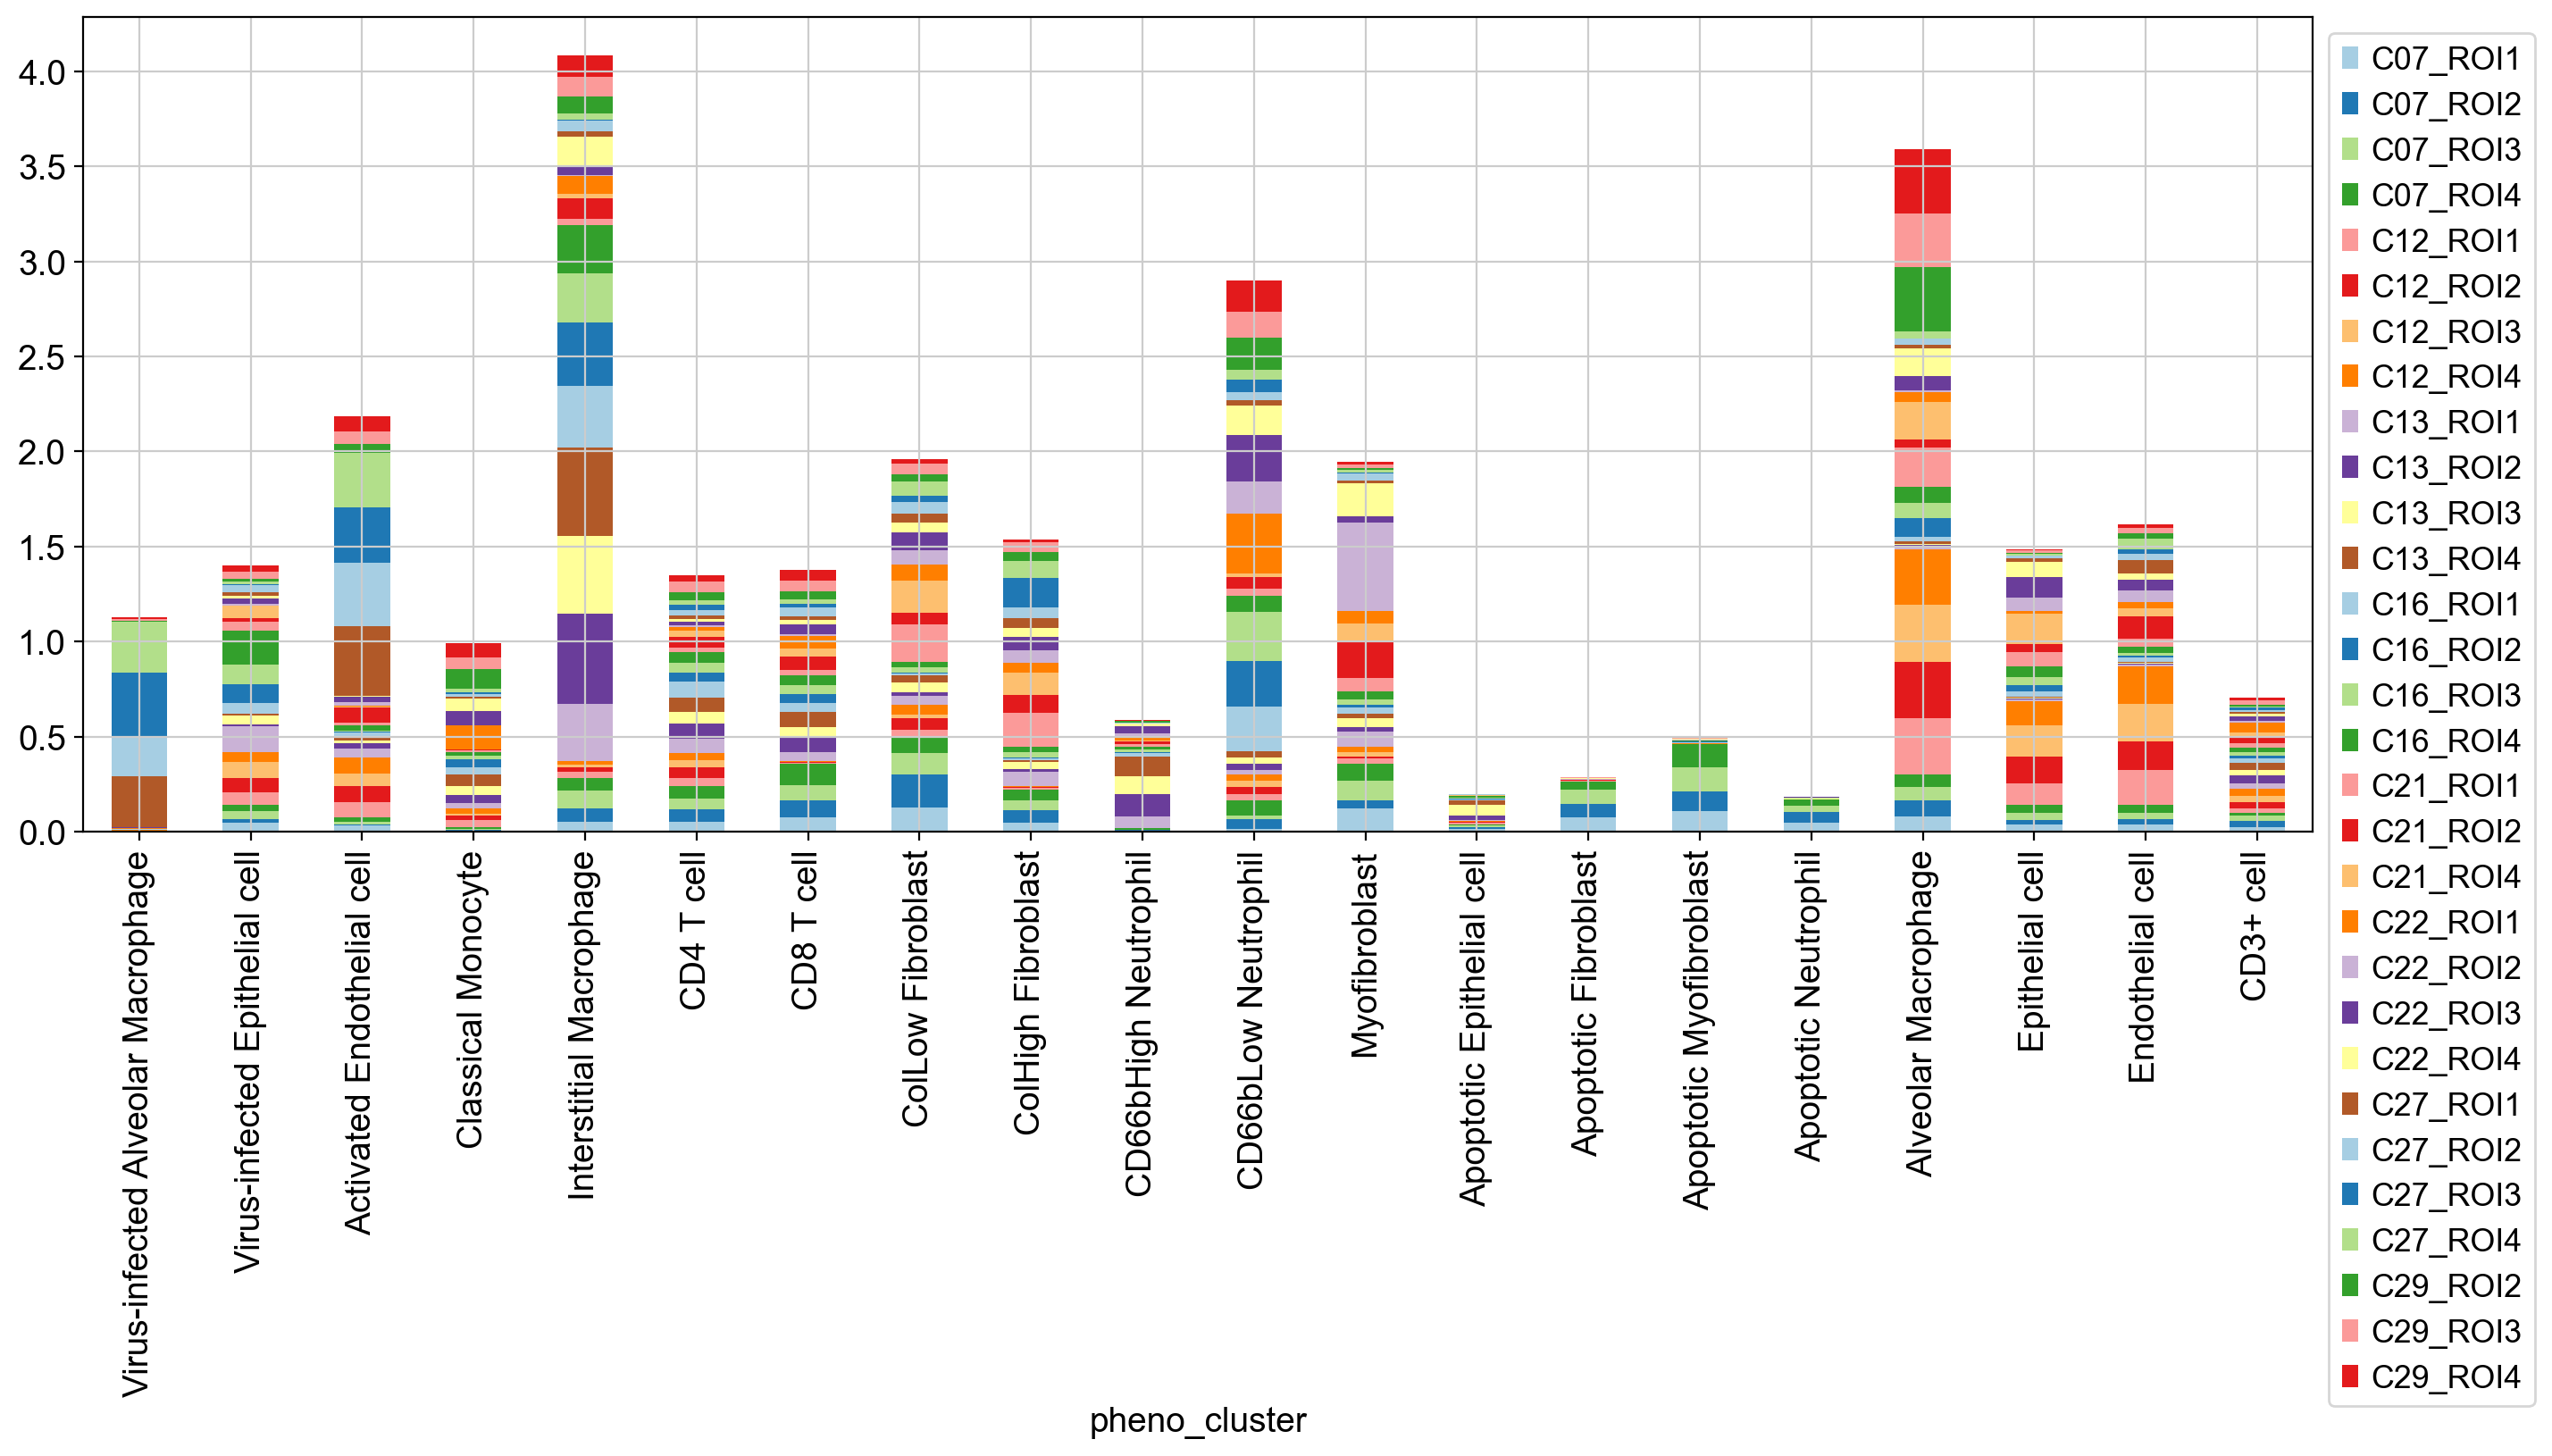

In [11]:
#color for stack bars for the disease groups matching the other bar graphs
#F08080 - light coral
#87CEFA - lightskyblue
#D3D3D3 - lightgrey

pretty_colors = ['#F08080','#87CEFA','#D3D3D3']
color_pal = sb.color_palette('Paired')

tmp2.plot.bar(stacked=True,color=color_pal, figsize=(16, 6)).legend(bbox_to_anchor=(1, 1))

In [32]:
tmp3 = pd.DataFrame.transpose(tmp2)

In [33]:
tmp3

pheno_cluster,Virus-infected Alveolar Macrophage,Virus-infected Epithelial cell,Activated Endothelial cell,Classical Monocyte,Interstitial Macrophage,CD4 T cell,CD8 T cell,ColLow Fibroblast,ColHigh Fibroblast,CD66bHigh Neutrophil,CD66bLow Neutrophil,Myofibroblast,Apoptotic Epithelial cell,Apoptotic Fibroblast,Apoptotic Myofibroblast,Apoptotic Neutrophil,Alveolar Macrophage,Epithelial cell,Endothelial cell,CD3+ cell
ROI,,,,,,,,,,,,,,,,,,,,
C07_ROI1,0.000313,0.047887,0.030673,0.004695,0.051643,0.051956,0.076682,0.127387,0.045383,0.005947,0.015649,0.121127,0.016275,0.076682,0.108607,0.044757,0.079812,0.035994,0.035681,0.022848
C07_ROI2,0.000000,0.017712,0.005226,0.003194,0.071429,0.065912,0.086527,0.173926,0.066492,0.003194,0.049942,0.045587,0.007549,0.068815,0.101626,0.058943,0.084495,0.027294,0.029617,0.032520
C07_ROI3,0.000000,0.040989,0.017209,0.006884,0.091677,0.058198,0.081352,0.112015,0.053817,0.002190,0.021277,0.100438,0.010325,0.076971,0.127972,0.030976,0.070713,0.033792,0.035670,0.027534
C07_ROI4,0.000000,0.035566,0.024303,0.010077,0.069354,0.062833,0.113811,0.084173,0.055720,0.006520,0.077060,0.091879,0.003557,0.042679,0.120332,0.034973,0.066983,0.046236,0.039715,0.014226
C12_ROI1,0.002633,0.066877,0.078989,0.035282,0.029489,0.042127,0.004213,0.038968,0.007372,0.000527,0.032649,0.026330,0.010532,0.004213,0.001053,0.000000,0.296998,0.109005,0.185361,0.027383
C12_ROI2,0.001428,0.071871,0.082818,0.022370,0.022846,0.058544,0.002856,0.060447,0.006663,0.000476,0.036649,0.009519,0.002380,0.002380,0.001428,0.000000,0.293194,0.141361,0.150881,0.031890
C12_ROI3,0.002114,0.086681,0.067125,0.013214,0.016913,0.036469,0.003171,0.017970,0.001586,0.001586,0.033827,0.023256,0.002643,0.000000,0.001586,0.000529,0.301797,0.164905,0.195032,0.029598
C12_ROI4,0.001305,0.049608,0.082245,0.028721,0.015666,0.039164,0.003264,0.050261,0.003916,0.000653,0.032637,0.030679,0.002611,0.001958,0.001958,0.000000,0.290470,0.129896,0.195822,0.039164
C13_ROI1,0.001689,0.138514,0.049662,0.028378,0.302027,0.074155,0.048142,0.048480,0.076182,0.060980,0.024155,0.075676,0.007432,0.001351,0.000338,0.000000,0.016047,0.008615,0.010980,0.027196


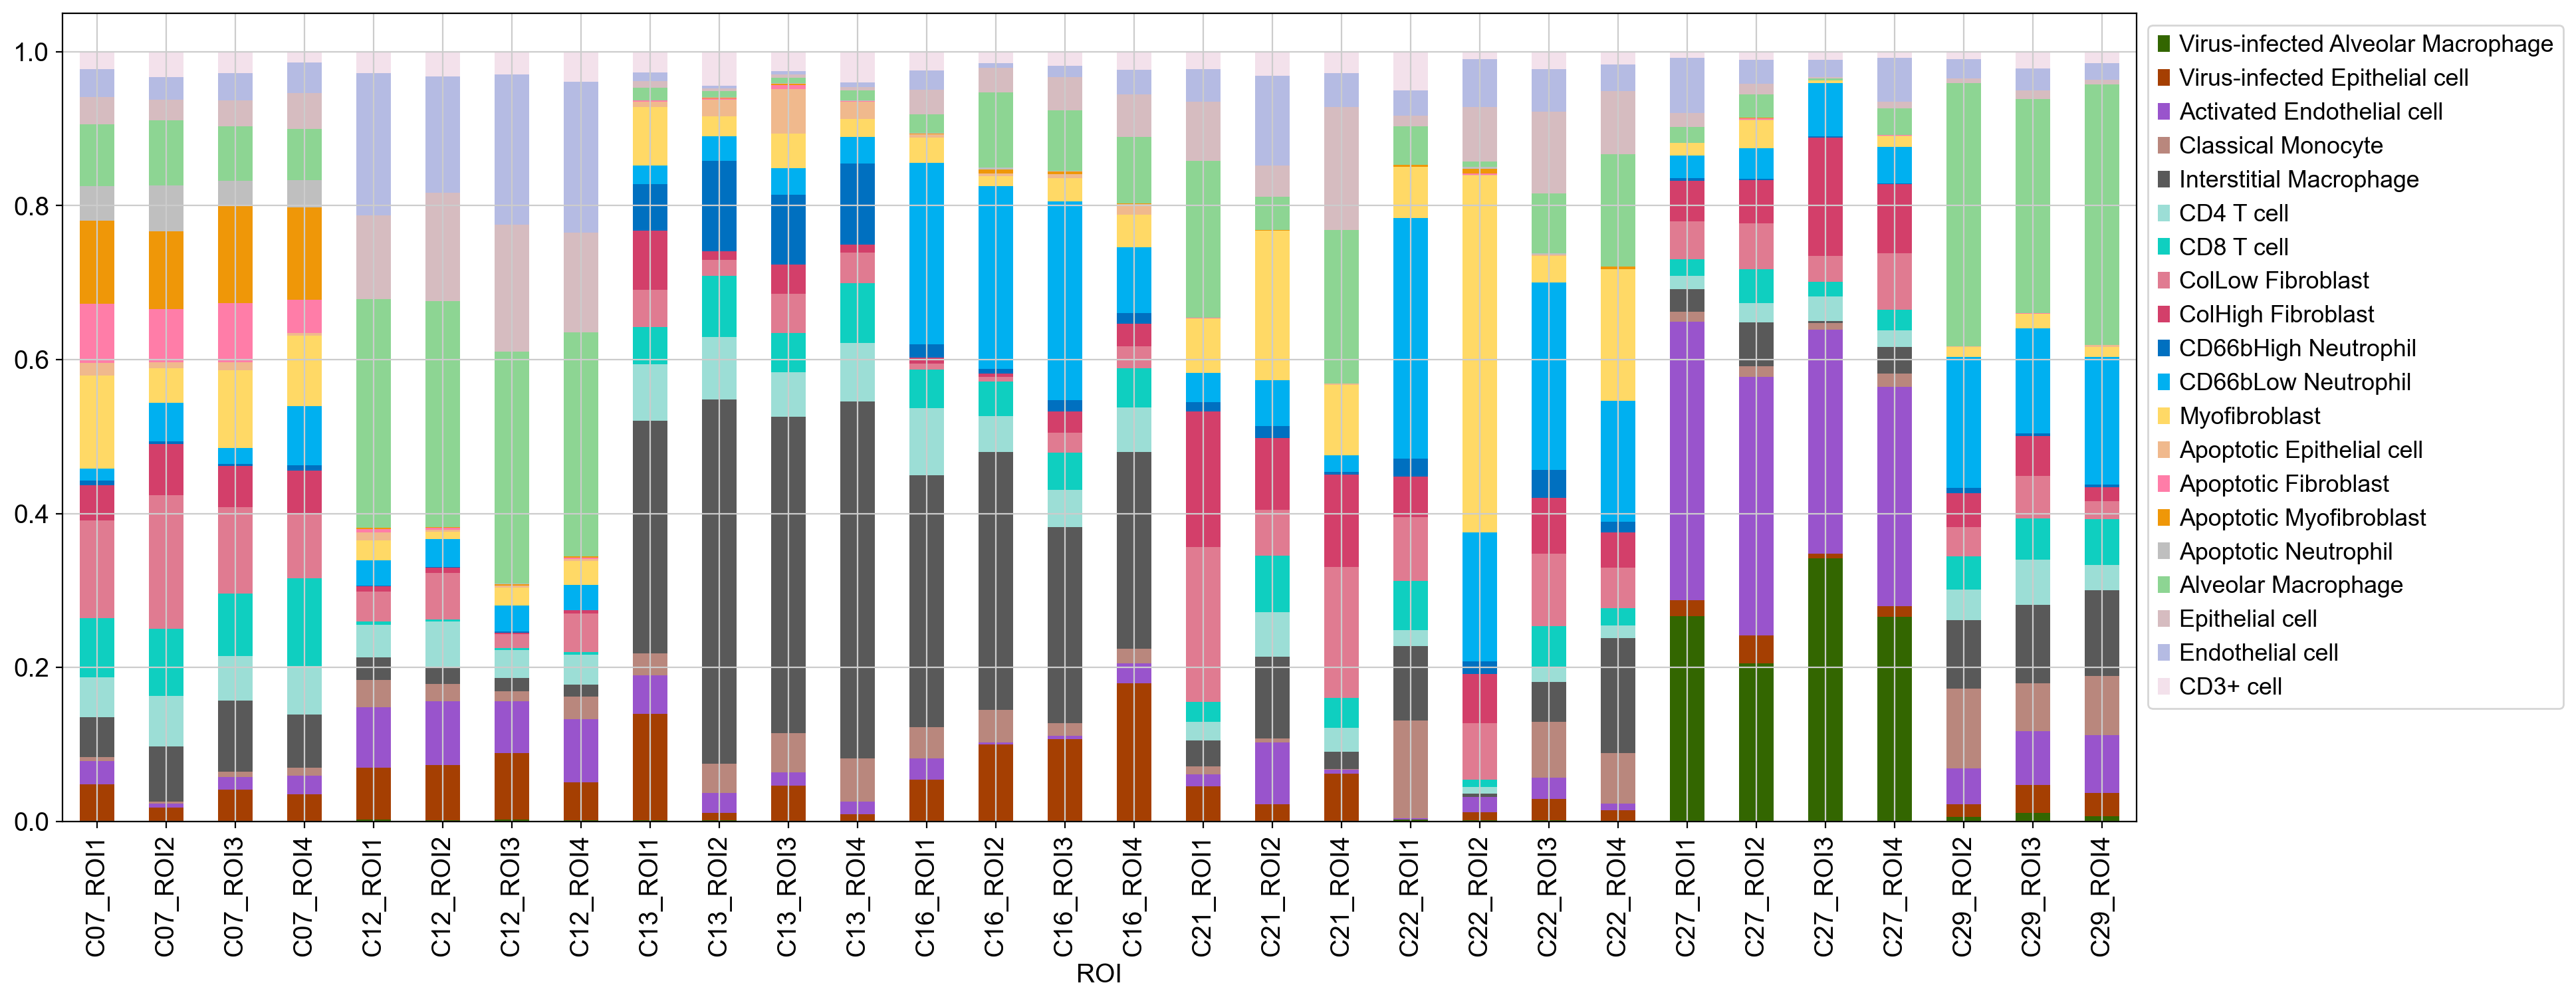

In [34]:
#color for stack bars for the disease groups matching the other bar graphs
#F08080 - light coral
#87CEFA - lightskyblue
#D3D3D3 - lightgrey

pretty_colors = ['#F08080','#87CEFA','#D3D3D3']
color_pal = sb.color_palette('Paired')
#colour_palette['colour']
tmp3.plot.bar(stacked=True, color=colour_palette['colour'], rot=90, figsize=(20, 8)).legend(bbox_to_anchor=(1, 1))  #use figsize=(16,6) or (8,8) for ROI
plt.savefig("Frequency_celltypes_ROI.pdf", format="pdf", bbox_inches="tight")

In [ ]:
compression_opts = dict(method='zip',
                         archive_name='Cell_type_number_per_ROI.csv') 
tmp3.to_csv('out.zip', index=True, compression=compression_opts)

In [ ]:
sc.pl.matrixplot(adata_covid, adata_covid.var_names, groupby='Type')

#Number of cells per case
print (adata_covid.obs['Type'].value_counts())

In [ ]:
adata_covid

In [ ]:
adata_covid.write_csvs(dirname='./', skip_data=False)

# MEFISTO - SPATIAL COVARIATE

In [ ]:
import cython

Add spatial covariate to the .obs slot so that we can refer to them easily later. I will use X_loc and Y_loc instead of "imagerow", "imagecol" as in the tutorial - you can skip this as the spatial covariate data is already contained in the X_loc and Y_loc columns

In [ ]:
#adata_covid.obs = pd.concat([adata_covid.obs, pd.DataFrame(adata_covid.obsm["spatial"], index=adata_covid.obs_names)], axis=1)

Train a MEFISTO model

In [ ]:
ent = entry_point()

In [ ]:
ent.set_data_options(use_float32=True)

In [ ]:
ent.set_data_from_anndata(adata_covid1)

In [ ]:
ent.set_model_options(factors=4)
ent.set_train_options(seed=2021)

In [ ]:
# We use 1000 inducing points to learn spatial covariance patterns
n_inducing = 1000

ent.set_covariates([adata_covid1.obsm["spatial"]], covariates_names=["X_loc", "Y_loc"])
ent.set_smooth_options(sparseGP=True, frac_inducing=n_inducing/adata_covid1.n_obs,
                       start_opt=10, opt_freq=10)

In [ ]:
%load_ext cython

In [ ]:
ent.build(adata_covid1)
ent.run(adata_covid1)
ent.save("Model_C07_ROI1.hdf5")

In [ ]:
#Load all the ROIs in the adata

ROI_list = adata_covid.obs["ROI"].unique().tolist()

for i in ROI_list:
        
        print('Calculating for '+i)
        working_adata = adata_covid[adata_covid.obs["ROI"]==i].copy()    
        
        ent = entry_point()
        ent.set_data_from_anndata(working_adata)
        ent.set_model_options(factors=2)
        ent.set_train_options(seed=2021)
        n_inducing = 1000
        ent.set_covariates([working_adata.obsm["spatial"]], covariates_names=["X_loc", "Y_loc"])
        ent.set_smooth_options(sparseGP=True, frac_inducing=n_inducing/working_adata.n_obs,
                       start_opt=10, opt_freq=10)
        ent.build()
          
        ent.run()
         
        ent.save('MEFISTO_model_'+i)


# Downstream analyses

In [ ]:
import mofax
m1 = mofax.mofa_model("MEFISTO_model_C13_ROI1")
m2 = mofax.mofa_model("MEFISTO_model_C13_ROI2")
m3 = mofax.mofa_model("MEFISTO_model_C13_ROI3")
m4 = mofax.mofa_model("MEFISTO_model_C13_ROI4")

In [ ]:
df1 = m1.get_factors(df=True)
df2 = m2.get_factors(df=True)
df3 = m3.get_factors(df=True)
df4 = m4.get_factors(df=True)

In [ ]:
df4

In [ ]:
#concatenate the df along rows
df_final = pd.concat([df1, df2, df3, df4], axis=0)

In [ ]:
df_final

# Factors correlation

In [ ]:
mofax.plot_factors_correlation(m1);

In [ ]:
mofax.plot_factors_correlation(m2);

In [ ]:
mofax.plot_factors_correlation(m3);

In [ ]:
mofax.plot_factors_correlation(m4);

# Spatial factors

We will then have a look at the spatial patterns that are captured by each factor.

In [ ]:
#adata.obs = adata.obs.join(m.get_factors(df=True))
adata_C13.obs = adata_C13.obs.join(df_final)

In [ ]:
adata_C13.obs

In [ ]:
fields=['C13_ROI1','C13_ROI2','C13_ROI3','C13_ROI4']
for i in fields:
    sc.pl.spatial(adata_C13[adata_C13.obs["ROI"] == i], color=[f"Factor{i+1}" for i in range(2)], spot_size=15, img_key=None, title=i, add_outline=True,return_fig=True)

# Weights

We will take Factor1 as an example to show the spatial expression pattern for genes that have the highest weights for that factor.

In [ ]:
top_features_f1 = m2.get_top_features(factors="Factor1", n_features=10)
top_features_f1

In [ ]:
top_features_f2 = m.get_top_features(factors="Factor2", n_features=10)
top_features_f2

In [ ]:
top_features_f3 = m.get_top_features(factors="Factor3", n_features=10)
top_features_f3

In [ ]:
top_features_f4 = m.get_top_features(factors="Factor4", n_features=10)
top_features_f4

In [ ]:
fields=['C13_ROI1','C13_ROI2','C13_ROI3','C13_ROI4']
for i in fields:
    sc.pl.spatial(adata_C13[adata_C13.obs["ROI"] == i], color=top_features_f1, spot_size=15, img_key=None, title=i, add_outline=True,return_fig=True)

In [ ]:
mofax.plot_smoothness(m2)